In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/aladdinpersson/flickr8kimagescaptions")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: titus-tanashi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/aladdinpersson/flickr8kimagescaptions


100%|██████████| 1.04G/1.04G [00:54<00:00, 20.3MB/s]

In [ ]:
# Install necessary libraries
!pip install nltk tqdm

In [ ]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import AdamW
from PIL import Image
import os
import nltk
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# 1. Set up the environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# # Load captions
# captions_file = "/content/drive/MyDrive/Colab Notebooks/LLM Projects/Flickr 8k/captions.txt"
# image_dir = "/content/drive/MyDrive/Colab Notebooks/LLM Projects/Flickr 8k/Images"
captions_file = "/content/flickr8kimagescaptions/flickr8k/captions.txt"
image_dir = "/content/flickr8kimagescaptions/flickr8k/images"

In [ ]:
# Configuration for PEFT
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "self.query",
        "self.key",
        "self.value",
        "output.dense",
        "self_attn.qkv",
        "self_attn.projection",
        "mlp.fc1",
        "mlp.fc2",
    ],
)

In [ ]:
# Load model and processor
model_id = "Salesforce/blip-image-captioning-base"
model = AutoModelForVision2Seq.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# Apply PEFT to the model
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,455,872 || all params: 252,869,948 || trainable%: 2.1576


In [ ]:
captions_dict = {}
with open(captions_file, 'r') as f:
  lines = f.readlines()
  for line in lines[1:]:
        parts = line.strip().split(',', 1)
        if len(parts) == 2:
            image_file, caption = parts
            if image_file not in captions_dict:
                captions_dict[image_file] = caption
            # captions_dict[image_file].append(caption)

In [ ]:
len(captions_dict)

8091

In [ ]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, image_dir, captions_dict, processor):
        self.image_dir = image_dir
        self.captions_dict = captions_dict
        self.image_files = list(captions_dict.keys())
        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert('RGB')
        caption = self.captions_dict[image_file]
        # caption = captions[0]  # Using the first caption for simplicity

        encoding = self.processor(images=image, padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = caption
        return encoding

def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [ ]:
# Load the custom dataset
# img_folder = "/content/drive/MyDrive/Colab Notebooks/LLM Projects/Flickr 8k/Images"
# captions_file = "/content/drive/MyDrive/Colab Notebooks/LLM Projects/Flickr 8k/captions.txt"
# full_dataset = FlickrImageCaptioningDataset(img_folder, captions_file, processor)
# Create dataset
full_dataset = ImageCaptioningDataset(image_dir, captions_dict, processor)

In [ ]:
full_dataset[0]

{'pixel_values': tensor([[[-0.9456, -0.1280, -0.2448,  ..., -1.7339, -1.7047, -1.7193],
          [-1.0039, -0.1280, -0.2302,  ..., -1.6901, -1.6463, -1.7631],
          [-1.0477, -0.1280, -0.2010,  ..., -1.6755, -1.7193, -1.5587],
          ...,
          [ 0.7625,  0.5873,  0.6603,  ...,  0.7041,  0.6603,  0.6603],
          [ 0.9814,  1.7406,  1.9303,  ...,  0.6895,  0.6749,  0.6749],
          [ 1.0836,  1.3172,  0.9814,  ...,  0.6895,  0.6457,  0.6749]],
 
         [[-0.9117,  0.1989,  0.0939,  ..., -1.6921, -1.6470, -1.6470],
          [-0.9567,  0.1989,  0.1089,  ..., -1.6170, -1.5420, -1.6771],
          [-1.0167,  0.1689,  0.1389,  ..., -1.6170, -1.6170, -1.4069],
          ...,
          [-0.4914, -0.2813,  0.2139,  ...,  1.0243,  0.9943,  1.0243],
          [-0.5215,  1.3245,  1.7147,  ...,  1.0393,  1.0093,  1.0093],
          [-0.2813,  0.3640, -0.3114,  ...,  1.0393,  1.0093,  0.9943]],
 
         [[-0.3995,  0.3399,  0.1835,  ..., -1.4376, -1.4091, -1.4376],
          [-

In [ ]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [ ]:
len(train_dataset), len(val_dataset)

(6472, 1619)

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=10, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=10, collate_fn=collate_fn)

In [ ]:
# Setup optimizer
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): BlipForConditionalGeneration(
      (vision_model): BlipVisionModel(
        (embeddings): BlipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (encoder): BlipEncoder(
          (layers): ModuleList(
            (0-11): 12 x BlipEncoderLayer(
              (self_attn): BlipAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=2304, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=2304, bias=False)
                  

In [ ]:
# Tracking losses for both training and validation
train_losses = []
val_losses = []

# Training loop
model.train()
for epoch in range(10):  # Adjust the number of epochs as needed
    print(f"Epoch {epoch + 1}/{10}")

    # Training phase
    model.train()
    train_epoch_loss = 0

    for batch in train_dataloader:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        attention_mask = batch.pop("attention_mask").to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            labels=input_ids,
            attention_mask=attention_mask,
        )

        loss = outputs.loss

        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss. Skipping batch.")
            continue

        # Backward pass
        loss.backward()

        # Gradient clipping (optional, helps prevent exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()

        # Accumulate loss
        train_epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = train_epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_epoch_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)
            attention_mask = batch.pop("attention_mask").to(device)

            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                labels=input_ids,
                attention_mask=attention_mask,
            )

            loss = outputs.loss
            val_epoch_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_epoch_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}")
    print(f"Average Training Loss: {avg_train_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

Epoch 1/10
Epoch 1
Average Training Loss: 4.4805
Average Validation Loss: 4.2832
Epoch 2/10
Epoch 2
Average Training Loss: 4.2300
Average Validation Loss: 4.2610
Epoch 3/10
Epoch 3
Average Training Loss: 4.1066
Average Validation Loss: 4.2609
Epoch 4/10
Epoch 4
Average Training Loss: 4.0445
Average Validation Loss: 4.2728
Epoch 5/10
Epoch 5
Average Training Loss: 3.9485
Average Validation Loss: 4.3156
Epoch 6/10
Epoch 6
Average Training Loss: 3.8609
Average Validation Loss: 4.3541
Epoch 7/10
Epoch 7
Average Training Loss: 3.7900
Average Validation Loss: 4.3994
Epoch 8/10
Epoch 8
Average Training Loss: 3.6737
Average Validation Loss: 4.4653
Epoch 9/10
Epoch 9
Average Training Loss: 3.6343
Average Validation Loss: 4.5269
Epoch 10/10
Epoch 10
Average Training Loss: 3.5739
Average Validation Loss: 4.6032



Final Results:
Training and Validation Losses per Epoch:
Epoch 1:
Training Loss: 4.4805
Validation Loss: 4.2832
------------------------------
Epoch 2:
Training Loss: 4.2300
Validation Loss: 4.2610
------------------------------
Epoch 3:
Training Loss: 4.1066
Validation Loss: 4.2609
------------------------------
Epoch 4:
Training Loss: 4.0445
Validation Loss: 4.2728
------------------------------
Epoch 5:
Training Loss: 3.9485
Validation Loss: 4.3156
------------------------------
Epoch 6:
Training Loss: 3.8609
Validation Loss: 4.3541
------------------------------
Epoch 7:
Training Loss: 3.7900
Validation Loss: 4.3994
------------------------------
Epoch 8:
Training Loss: 3.6737
Validation Loss: 4.4653
------------------------------
Epoch 9:
Training Loss: 3.6343
Validation Loss: 4.5269
------------------------------
Epoch 10:
Training Loss: 3.5739
Validation Loss: 4.6032
------------------------------


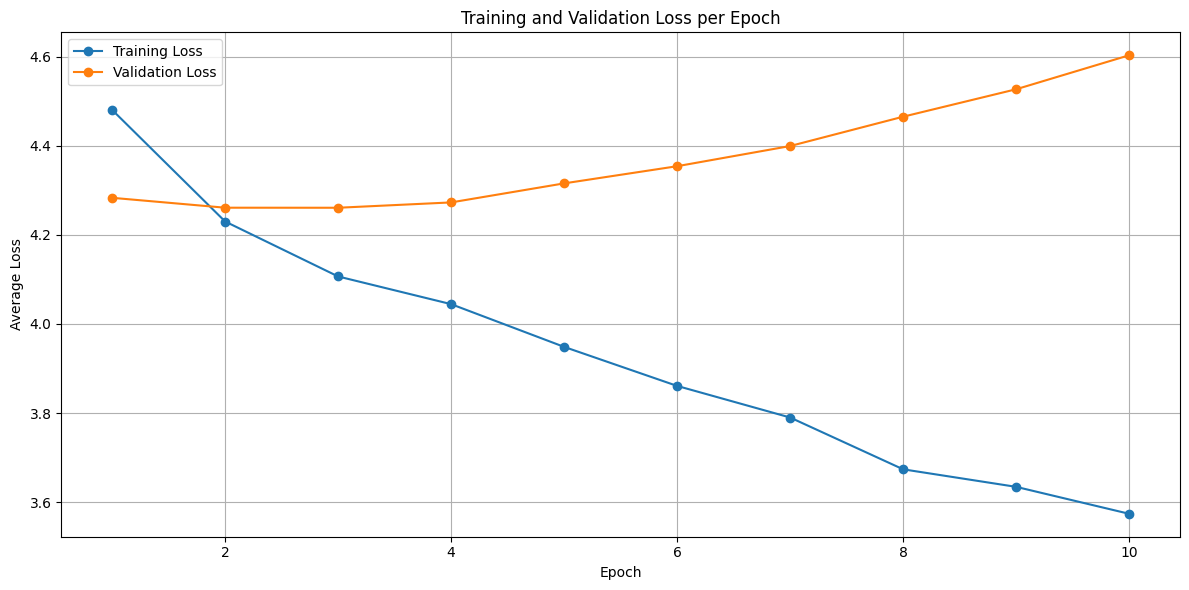

In [ ]:
import matplotlib.pyplot as plt
# Visualization of Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('/content/training_validation_loss_plot.png')

# Save losses to a text file for further analysis
with open('/content/training_validation_losses.txt', 'w') as f:
    for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses), 1):
        f.write(f"Epoch {i}:\n")
        f.write(f"Training Loss: {train_loss:.4f}\n")
        f.write(f"Validation Loss: {val_loss:.4f}\n")
        f.write("-" * 30 + "\n")

# Save the fine-tuned model
model.save_pretrained('/content/caption')
processor.save_pretrained('/content/processor')

# Print out the final losses for immediate reference
print("\nFinal Results:")
print("Training and Validation Losses per Epoch:")
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses), 1):
    print(f"Epoch {i}:")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print("-" * 30)